# **Comparative Analysis of Speech emotion recognition**

#### Why we chose SVM as one of our models to do the comparative analysis
- https://ieeexplore.ieee.org/document/6512793


### Importing necessary libraries

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchaudio
import os
from torchaudio.transforms import Resample
import seaborn as sns

### Data-Loading and resampling
- We are loading the SAVEE dataset and resampling it to 16000kHz to ensure common sampling rate when we combine these datasets together

In [2]:
# Step 1: Load & Resample Audio
dataset_path = r"F:/CompAnalysis/SAVEE"
audio_files = [f for f in os.listdir(dataset_path) if f.endswith('.wav')]

target_sr = 16000  # Target sample rate

def load_audio_files(path, file_list, target_sr=None):
    audio_data = {}
    for file in file_list:
        file_path = os.path.join(path, file)
        signal, sr = librosa.load(file_path, sr=None)  # Load original sample rate
        if target_sr and sr != target_sr:
            signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
            sr = target_sr  # Update sample rate
        audio_data[file] = (signal, sr)
    return audio_data

# Load all audio files with resampling
audio_data = load_audio_files(dataset_path, audio_files, target_sr=16000)

- Visualising the Original Waveform and spectrogram

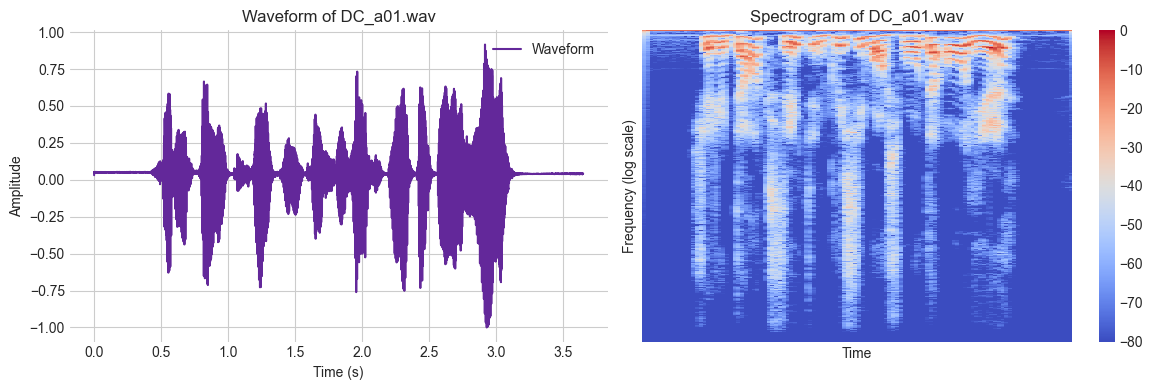

In [15]:
sns.set_style("whitegrid")

# Load the first audio file
first_file = audio_files[0]
signal, sr = audio_data[first_file]

# Create a side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Waveform plot with "forbes" palette color
sns.lineplot(
    x=np.linspace(0, len(signal) / sr, num=len(signal)), 
    y=signal, 
    label="Waveform", 
    color=sns.color_palette("dark:#8A2BE2", as_cmap=True)(0.6), 
    ax=axes[0]
)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Waveform of {first_file}")
axes[0].legend()

# Spectrogram plot
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
sns.heatmap(D, cmap="coolwarm", cbar=True, xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_title(f"Spectrogram of {first_file}")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Frequency (log scale)")

plt.tight_layout()
plt.show()


- Using voice activity detection (VAD) we are trimming silence using adaptive thresholding, When playing around with the values we found out that 1.2 and 0.9 are the better values with 0.9 being even more accurate

In [4]:
def vad_trim(signal, sr):
    """Applies VAD trimming using adaptive thresholding."""
    rms_energy = librosa.feature.rms(y=signal, frame_length=1024, hop_length=512)[0]
    threshold = np.median(rms_energy) * 0.9  # Adaptive thresholding
    voiced_frames = rms_energy > threshold
    
    if np.any(voiced_frames):
        non_silent_indices = np.where(voiced_frames)[0]
        start = max(0, non_silent_indices[0] * 512)  # Convert frame index to sample index
        end = min(len(signal), non_silent_indices[-1] * 512)
        signal = signal[start:end]
    
    return signal

# Store VAD-trimmed audio separately
vad_audio_data = {file: (vad_trim(data[0], data[1]), data[1]) for file, data in audio_data.items()}


In [5]:
first_file = audio_files[0]
original_signal, sr = audio_data[first_file]
trimmed_signal = vad_trim(original_signal, sr)

print(f"Original Length: {len(original_signal)}, Trimmed Length: {len(trimmed_signal)}")

Original Length: 58365, Trimmed Length: 40960


- We are choosing the first file of the dataset to visualise our pre processing steps done
- We are plotting original waveform and VAD Trimmed waveform

In [6]:
# Pick a file for visualization
first_file = audio_files[0]
original_signal, sr = audio_data[first_file]  # Original
trimmed_signal, _ = vad_audio_data[first_file]  # Trimmed

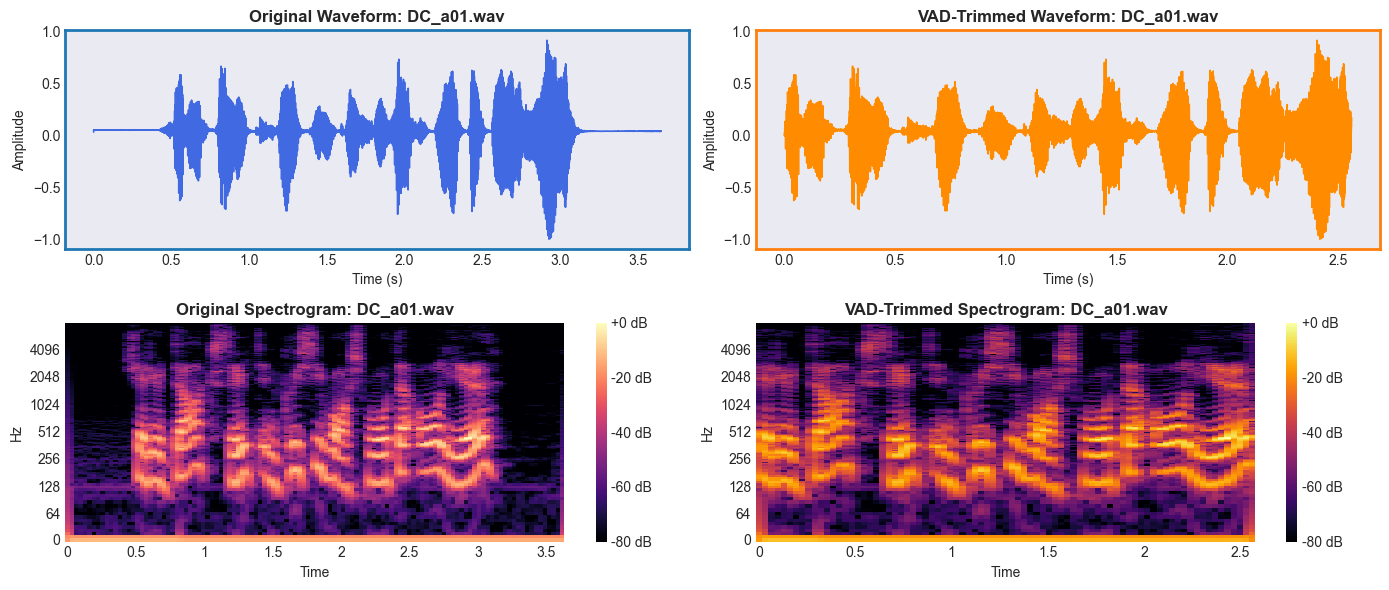

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for aesthetics
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-dark")

def plot_waveform_and_spectrogram(original, trimmed, sr, filename):
    """Visualizes original and trimmed waveforms & spectrograms side by side with borders only for waveforms."""
    fig, ax = plt.subplots(2, 2, figsize=(14, 6))

    # Time Axis
    time_orig = np.linspace(0, len(original) / sr, num=len(original))
    time_trim = np.linspace(0, len(trimmed) / sr, num=len(trimmed))

    # Define border colors for waveforms
    border_colors = ["#1f77b4", "#ff7f0e"]  # Blue for Original, Orange for Trimmed

    # Original Waveform (With Border)
    ax[0, 0].plot(time_orig, original, color="royalblue", linewidth=1.2)
    ax[0, 0].set_title(f"Original Waveform: {filename}", fontsize=12, fontweight="bold")
    ax[0, 0].set_xlabel("Time (s)")
    ax[0, 0].set_ylabel("Amplitude")

    # Trimmed Waveform (With Border)
    ax[0, 1].plot(time_trim, trimmed, color="darkorange", linewidth=1.2)
    ax[0, 1].set_title(f"VAD-Trimmed Waveform: {filename}", fontsize=12, fontweight="bold")
    ax[0, 1].set_xlabel("Time (s)")
    ax[0, 1].set_ylabel("Amplitude")

    # Original Spectrogram (No Border)
    D_original = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
    img1 = librosa.display.specshow(D_original, sr=sr, x_axis="time", y_axis="log", cmap="magma", ax=ax[1, 0])
    ax[1, 0].set_title(f"Original Spectrogram: {filename}", fontsize=12, fontweight="bold")
    fig.colorbar(img1, ax=ax[1, 0], format="%+2.0f dB")

    # Trimmed Spectrogram (No Border)
    D_trimmed = librosa.amplitude_to_db(np.abs(librosa.stft(trimmed)), ref=np.max)
    img2 = librosa.display.specshow(D_trimmed, sr=sr, x_axis="time", y_axis="log", cmap="inferno", ax=ax[1, 1])
    ax[1, 1].set_title(f"VAD-Trimmed Spectrogram: {filename}", fontsize=12, fontweight="bold")
    fig.colorbar(img2, ax=ax[1, 1], format="%+2.0f dB")

    # Add Borders ONLY for Waveforms
    for i in range(2):  # Only top row (waveforms)
        for spine in ax[0, i].spines.values():
            spine.set_edgecolor(border_colors[i])  # Set border color
            spine.set_linewidth(2)  # Set border thickness

    plt.tight_layout()
    plt.show()

# Pick a file for visualization
first_file = list(audio_data.keys())[0]
original_signal, sr = audio_data[first_file]
trimmed_signal, _ = vad_audio_data[first_file]

# Plot Pretty Visualizations
plot_waveform_and_spectrogram(original_signal, trimmed_signal, sr, first_file)


- For a Pytorch training loop we should convert it to a tensor. This is the input of the model ( Tensor )

In [8]:
torch_audio_data = {file: torch.tensor(data[0], dtype=torch.float32) for file, data in audio_data.items()}
print(f"Loaded {len(torch_audio_data)} audio files. Sample rate: {sr}")


Loaded 480 audio files. Sample rate: 16000


### Feature Extraction - extracting multiple features and saving them

- As this is a multifeature multimodal comparative analysis, We are extractine MFCC with 13 coefficients and MFCC with 40 coefficients and MFCC with Delta(Δ) First derivative and Double-Delta(Δ) Second Derivative

In [9]:
import librosa
import numpy as np
import os
import torch
import pickle

- The extracted features are MFCC 13 and 40 and Delta and Double Delta. They are saved in the features folder in the dataset path. 
- We are assesing all the frames and setting an optimal value for max_frames to ensure there is no unnecessary padding

In [10]:
dataset_path = "F:/CompAnalysis/SAVEE"
feature_dir = os.path.join(dataset_path, "features")
os.makedirs(feature_dir, exist_ok=True)

# Define emotion label mapping (SAVEE encoding)
emotion_mapping = {
    "a": 0,  # Anger
    "d": 1,  # Disgust
    "f": 2,  # Fear
    "h": 3,  # Happiness
    "n": 4,  # Neutral
    "s": 5,  # Sadness
    "su": 6  # Surprise
}

# Get all audio files
audio_files = [f for f in os.listdir(dataset_path) if f.endswith(".wav")]

# Store frame lengths for analysis
frame_lengths = []

# Analyze dataset to determine optimal max_frames
for file in audio_files:
    file_path = os.path.join(dataset_path, file)
    signal, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    frame_lengths.append(mfcc.shape[1])

# Compute 95th percentile frame length (avoids extreme outliers)
max_frames = int(np.percentile(frame_lengths, 95))
print(f"Optimal frame length: {max_frames}")

# Initialize feature storage
mfcc_features_13, mfcc_delta_features, mfcc_40_features, labels, filenames = [], [], [], [], []

for file in audio_files:
    file_path = os.path.join(dataset_path, file)
    
    # Extract label from filename
    emotion_code = file.split("_")[1][0]  # Get the first letter after '_'
    if emotion_code not in emotion_mapping:
        continue  # Skip unknown labels
    label = emotion_mapping[emotion_code]

    # Load audio
    signal, sr = librosa.load(file_path, sr=16000)
    
    # Compute MFCC-13
    mfcc_13 = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    
    # Compute Delta (Δ) and Double Delta (ΔΔ)
    delta = librosa.feature.delta(mfcc_13, width=5)
    ddelta = librosa.feature.delta(mfcc_13, order=2, width=5)
    mfcc_delta_dd = np.vstack([delta, ddelta])  # MFCC-ΔΔ (26D)
    
    # Compute MFCC-40 (higher resolution MFCC without delta/double delta)
    mfcc_40 = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40)

    # Pad or truncate to max_frames
    def pad_or_truncate(feature):
        if feature.shape[1] < max_frames:
            pad_width = max_frames - feature.shape[1]
            return np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
        else:
            return feature[:, :max_frames]

    mfcc_13 = pad_or_truncate(mfcc_13)
    mfcc_delta_dd = pad_or_truncate(mfcc_delta_dd)
    mfcc_40 = pad_or_truncate(mfcc_40)

    # Store features and labels
    mfcc_features_13.append(mfcc_13)
    mfcc_delta_features.append(mfcc_delta_dd)
    mfcc_40_features.append(mfcc_40)
    labels.append(label)
    filenames.append(file)

# Convert lists to NumPy arrays
mfcc_features_13 = np.array(mfcc_features_13)
mfcc_delta_features = np.array(mfcc_delta_features)
mfcc_40_features = np.array(mfcc_40_features)
labels = np.array(labels)

# Save features and labels
np.save(os.path.join(feature_dir, "mfcc_13.npy"), mfcc_features_13)
np.save(os.path.join(feature_dir, "mfcc_delta_dd.npy"), mfcc_delta_features)
np.save(os.path.join(feature_dir, "mfcc_40.npy"), mfcc_40_features)
np.save(os.path.join(feature_dir, "labels.npy"), labels)

# Save metadata (filenames)
with open(os.path.join(feature_dir, "filenames.pkl"), "wb") as f:
    pickle.dump(filenames, f)

print("Feature extraction complete. Files saved.")


Optimal frame length: 184
Feature extraction complete. Files saved.


### Prepare the Dataloader and set up training operations

####  - Dataset Preparation for SER  

- Feature Extraction: Three types of MFCC features extracted:  
  - MFCC-13 (Base)  
  - MFCC-ΔΔ (Delta & Delta-Delta)  
  - MFCC-40 (Extended)  

- Dataset Class (`SERDataset`):  
  - Stores features and labels in PyTorch tensors.  
  - Supports dynamic feature selection (`mfcc_13`, `mfcc_dd`, `mfcc_40`).  

- Train-Test Split:  
  - 80% training, 20% testing (Stratified).  

- Dataloaders:  
  - train_loader & test_loader for batch processing (Batch size: 32).  

Feature type can be switched easily before training.

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Load extracted features and labels
mfcc_13_features = np.load("SAVEE/features/mfcc_13.npy")  # Shape: [num_samples, time_steps, 13]
mfcc_delta_features = np.load("SAVEE/features/mfcc_delta_dd.npy")  # Shape: [num_samples, time_steps, 13]
mfcc_40_features = np.load("SAVEE/features/mfcc_40.npy")  # Shape: [num_samples, time_steps, 40]
labels = np.load("SAVEE/features/labels.npy")  # Shape: [num_samples]

class SERDataset(Dataset):
    def __init__(self, mfcc_13, mfcc_dd, mfcc_40, labels, feature_type="mfcc_13"):
        self.features = {
            "mfcc_13": torch.tensor(mfcc_13, dtype=torch.float32),
            "mfcc_dd": torch.tensor(mfcc_dd, dtype=torch.float32),
            "mfcc_40": torch.tensor(mfcc_40, dtype=torch.float32),
        }
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.feature_type = feature_type  # Default: MFCC-13

    def set_feature_type(self, feature_type):
        assert feature_type in self.features, "Invalid feature type"
        self.feature_type = feature_type

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[self.feature_type][idx], self.labels[idx]

# Split dataset (80% train, 20% test)
X_train_13, X_test_13, X_train_dd, X_test_dd, X_train_40, X_test_40, y_train, y_test = train_test_split(
    mfcc_13_features, mfcc_delta_features, mfcc_40_features, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = SERDataset(X_train_13, X_train_dd, X_train_40, y_train, feature_type="mfcc_13")
test_dataset = SERDataset(X_test_13, X_test_dd, X_test_40, y_test, feature_type="mfcc_13")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
import numpy as np
import os

# Path to your .npy files
folder_path = r"F:\CompAnalysis\SAVEE\features"

# List all .npy files in the folder
npy_files = [f for f in os.listdir(folder_path) if f.endswith(".npy")]

# Print the shape of each .npy file
for file in npy_files:
    file_path = os.path.join(folder_path, file)
    data = np.load(file_path)
    print(f"{file}: {data.shape}")


combined_features.npy: (0,)
features.npy: (480, 42, 184)
features_pca.npy: (480, 394)
labels.npy: (480,)
mfcc_13.npy: (480, 13, 184)
mfcc_40.npy: (480, 40, 184)
mfcc_delta_dd.npy: (480, 26, 184)
mfcc_mel.npy: (480, 80, 184)


## Model Training and Evaluation.

- First we are training the model on MFCC 13 Features

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.4271
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.42      0.40        12
           1       0.40      0.17      0.24        12
           2       0.33      0.17      0.22        12
           3       0.00      0.00      0.00        12
           4       0.71      0.83      0.77        24
           5       0.30      0.50      0.38        24

    accuracy                           0.43        96
   macro avg       0.36      0.35      0.33        96
weighted avg       0.39      0.43      0.39        96



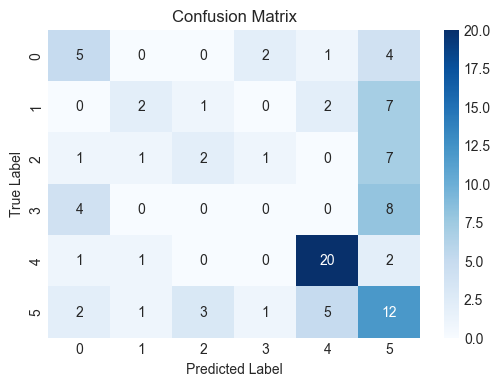

In [27]:
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load features and labels
mfcc_features = np.load("SAVEE/features/mfcc_13.npy")  # Shape: [num_samples, time_steps, 13]
labels = np.load("SAVEE/features/labels.npy")  # Shape: [num_samples]

# Flatten MFCC features for SVM (SVM requires 2D input)
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
y = labels

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

# Initialize SVM model
svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final SVM model with best parameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


- Lets train the model on MFCC 40

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.5208
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.67      0.33      0.44        12
           2       1.00      0.17      0.29        12
           3       0.50      0.25      0.33        12
           4       0.66      0.79      0.72        24
           5       0.36      0.67      0.46        24

    accuracy                           0.52        96
   macro avg       0.65      0.45      0.47        96
weighted avg       0.62      0.52      0.50        96



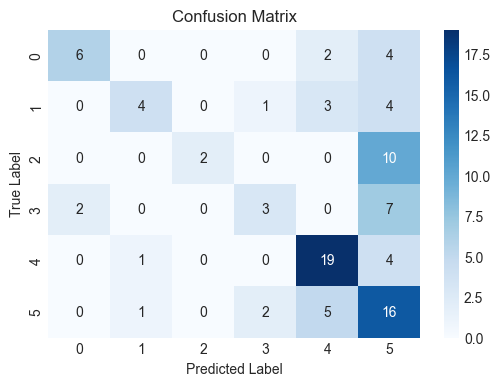

In [ ]:
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load features and labels
mfcc_features = np.load("SAVEE/features/mfcc_40.npy")  # Shape: [num_samples, time_steps, 40]
labels = np.load("SAVEE/features/labels.npy")  # Shape: [num_samples]

# Flatten MFCC features for SVM (SVM requires 2D input)
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
y = labels

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

# Initialize SVM model
svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final SVM model with best parameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


- Lets train the model on MFCC Delta and Double Delta features

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.2500
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.00      0.00      0.00        12
           2       0.33      0.17      0.22        12
           3       0.00      0.00      0.00        12
           4       0.50      0.54      0.52        24
           5       0.18      0.38      0.24        24

    accuracy                           0.25        96
   macro avg       0.17      0.18      0.16        96
weighted avg       0.21      0.25      0.22        96



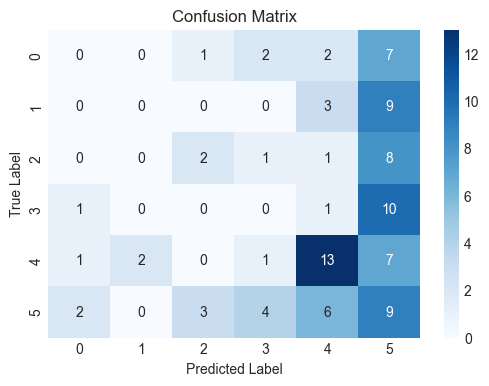

In [24]:
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load features and labels
mfcc_features = np.load("SAVEE/features/mfcc_delta_dd.npy") 
labels = np.load("SAVEE/features/labels.npy")  # Shape: [num_samples]

# Flatten MFCC features for SVM (SVM requires 2D input)
X = mfcc_features.reshape(mfcc_features.shape[0], -1)
y = labels

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

# Initialize SVM model
svm = SVC()

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final SVM model with best parameters
best_svm = SVC(**grid_search.best_params_)
best_svm.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_svm.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Comparative Analysis of MFCC-Based SVM approach

| Feature Set | Best Parameters | Test Accuracy | Avg Precision | Avg Recall | Avg F1-score |
|------------|----------------|--------------|---------------------|------------------|------------------|
| **MFCC-13** | C: 10, gamma: scale, kernel: rbf| 42.71% | 0.36 | 0.35 | 0.33 |
| **MFCC-40** | C: 10, gamma: scale, kernel: rbf| 52.08% | 0.65 | 0.45 | 0.47 |
| **MFCC-DD** | C: 10, gamma: scale, kernel: rbf| 25.00% | 0.17 | 0.18 | 0.16 |


### Inference
- MFCC-40 performs the best with 52.08% accuracy, indicating that higher-dimensional MFCCs capture more emotional variations.  

- MFCC-13 is a strong baseline, but performs worse than MFCC-40. 

- MFCC-DD alone is insufficient, achieving only 25% accuracy, suggesting that delta/delta-delta features need to be combined with MFCCs for better performance.

- **As SAVEE dataset has only 480 samples it performs poorly in most of the cases when used without any additional training data**